In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator



In [3]:
import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)




In [4]:
background = None
accumulated_weight = 0.5

#Creating the dimensions for the ROI...
ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350


def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [5]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    _ , thresholded = cv2.threshold(diff, threshold,255,cv2.THRESH_BINARY)

    # Grab the external contours for the image
    contours, hierarchy = cv2.findContours(thresholded.copy(),
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return (thresholded, hand_segment_max_cont)

In [36]:

cam = cv2.VideoCapture(1)
num_frames = 0
element =9
num_imgs_taken = 0
while True:
    ret, frame = cam.read()
    # flipping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)
    frame_copy = frame.copy()
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]
    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",
(80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            
    #Time to configure the hand specifically into the ROI...
    elif num_frames <= 300: 
        hand = segment_hand(gray_frame)
        
        cv2.putText(frame_copy, "Adjust hand...Gesture for" +
        str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,
        (0,0,255),2)
        
        # Checking if the hand is actually detected by counting the number of contours detected...
        if hand is not None:
            
            thresholded, hand_segment = hand
            # Draw contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
            ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames)+"For" + str(element),
            (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            # Also display the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
    
    else: 
        
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand
            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
            ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For"
      + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,
      (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
            if num_imgs_taken <= 300:
                cv2.imwrite(r"D:\\self_project_frameworks\\hand action rec\\new\\gestures\\"+str(element)+"\\" +
                str(num_imgs_taken+300) + '.jpg', thresholded)
                
            else:
                break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400),
 cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1
    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)
    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
# Releasing the camera & destroying all the windows...
cv2.destroyAllWindows()
cam.release()

In [37]:
import pathlib
data_dir = r"D:\self_project_frameworks\hand action rec\new\gestures"
data_dir = pathlib.Path(data_dir)

In [39]:
import splitfolders
splitfolders.ratio('gestures', output="output", seed=1337, ratio=(.8, 0.1,0.1))

In [40]:
train_path = r'D:\self_project_frameworks\hand action rec\new\output\train'
test_path = r'D:\self_project_frameworks\hand action rec\new\output\test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

Found 6498 images belonging to 9 classes.
Found 819 images belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

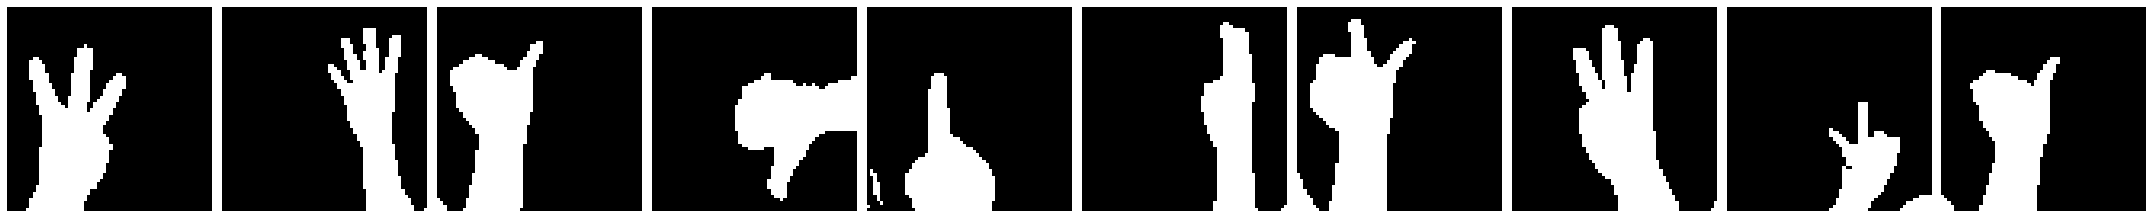

(10, 64, 64, 3)
[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [41]:
imgs, labels = next(train_batches)
import matplotlib.pyplot as plt
#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)

In [42]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(9,activation ="softmax"))

In [43]:
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [44]:
history2 = model.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)

Epoch 1/10
650/650 [==============================] - 105s 161ms/step - loss: 0.4092 - accuracy: 0.9109 - val_loss: 0.0221 - val_accuracy: 0.9939 - lr: 0.0010
Epoch 2/10
650/650 [==============================] - 66s 101ms/step - loss: 0.0062 - accuracy: 0.9992 - val_loss: 0.0030 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
650/650 [==============================] - 63s 97ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.0022 - val_accuracy: 0.9988 - lr: 0.0010
Epoch 4/10
650/650 [==============================] - 63s 98ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0015 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
650/650 [==============================] - 65s 100ms/step - loss: 7.8820e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
650/650 [==============================] - 49s 76ms/step - loss: 6.1696e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
650/650 [==========================

In [50]:
# For getting next batch of testing imgs...
imgs, labels = next(test_batches) 

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


#Once the model is fitted we save the model using model.save()  function.


model.save('hand_model_new.h5')

loss of 0.0001537102070869878; accuracy of 100.0%


In [46]:
import numpy as np
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

predictions on a small set of test data--

five four one four five three one five one eight 

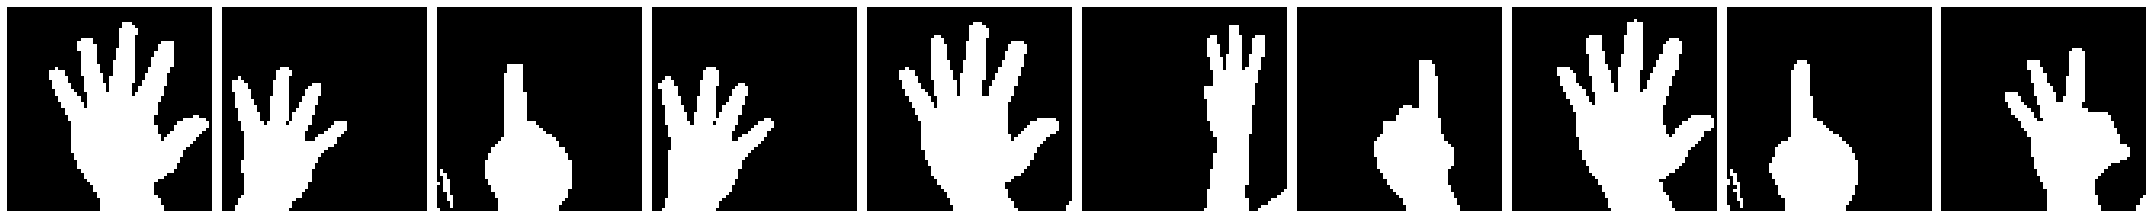

Actual labels
five   four   one   four   five   three   one   five   one   eight   

In [47]:
word_dict = {0:'one', 1:'two', 2:'three', 3:'four', 4:'five', 5:'six', 6:'seven', 7:'eight', 8:'nine'}

predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)],end=' ')

plotImages(imgs)
print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')


In [51]:
model = keras.models.load_model(r"D:\self_project_frameworks\hand action rec\new\hand_model_new.h5")
background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

In [52]:
def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [53]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    
    _ , thresholded = cv2.threshold(diff, threshold, 255,
    cv2.THRESH_BINARY)
    
     #Fetching contours in the frame (These contours can be of hand
    #or any other object in foreground) …

    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # If length of contours list = 0, means we didn't get any#contours...
    if len(contours) == 0:
        return None
    else:
        # The largest external contour should be the hand 
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        # Returning the hand segment(max contour) and the
  #thresholded image of hand...
        return (thresholded, hand_segment_max_cont)

In [54]:
cam = cv2.VideoCapture(1)
num_frames =0
while True:
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured
    #frame...
    
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    # ROI from the frame
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)


    if num_frames < 70:
        
        cal_accum_avg(gray_frame, accumulated_weight)
        
        cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",
  (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    
    else: 
        # segmenting the hand region
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
      ROI_top)], -1, (255, 0, 0),1)
            
            cv2.imshow("Thesholded Hand Image", thresholded)
            
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded,
 cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded,
(1,thresholded.shape[0],thresholded.shape[1],3))
            
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)],
(170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
    # Draw ROI on frame_copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,
    ROI_bottom), (255,128,0), 3)

    # incrementing the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _",
    (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)


    # Close windows with Esc
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()